## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [9]:
!chmod 600 .s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=.s3_passwd -o ro

Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [10]:
!ls mnt/

geo_dataframe.csv  requests  train_users.csv


Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [ ]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

## Опции

In [1]:
#prefix = 's3'
prefix = '.'

low_memory = True

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [43]:
import pandas as pd
import polars as pl

geo = pd.read_csv(prefix+'/geo_dataframe.csv')
#geo = pl.read_csv(prefix+'/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [44]:
users = pd.read_csv(prefix+'/train_users.csv')
#users = pl.read_csv(prefix+'/train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<Axes: xlabel='gender'>

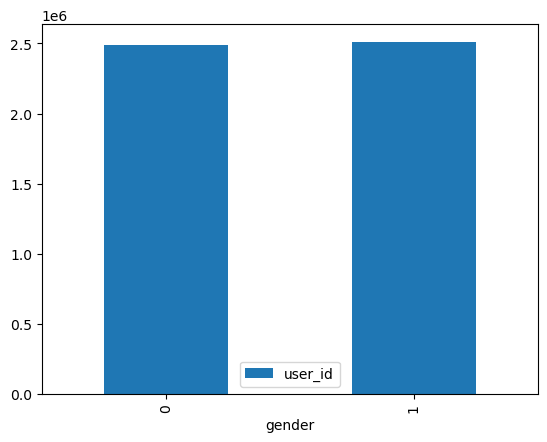

In [3]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

<Axes: xlabel='age'>

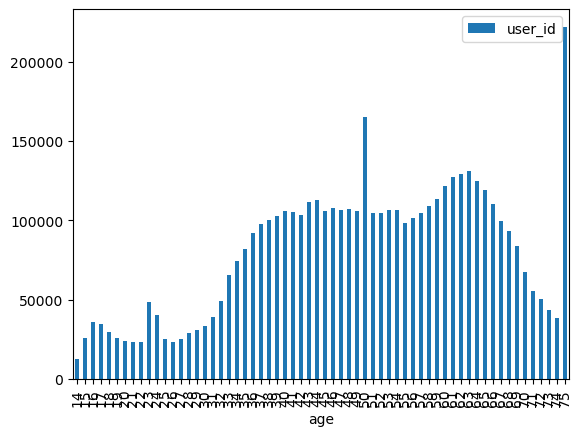

In [3]:
users.groupby('age').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [5]:
req1 = pd.read_parquet(prefix+'/requests/part_0.parquet')
req1

,timestamp,geo_id,referer,user_id,user_agent
0,1712169477,1224,https://www.domain_1118/path_107938,1628092,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
1,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...
2,1712154596,4402,https://domain_2194/path_172150,8274161,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...
10000449,1712161101,702,https://domain_662/path_131980,2062442,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
10000450,1711940706,3515,https://domain_1784/path_45033,2375719,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
10000451,1712107755,3173,https://domain_1654/path_48166,11781572,Mozilla/5.0 (Linux; arm_64; Android 13; SM-A14...
10000452,1712107427,3833,https://domain_1654/path_10504,15183751,Mozilla/5.0 (Linux; arm_64; Android 12; SM-M21...


## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

### util

In [8]:
import time
import datetime

#current_time = time.time()
current_time = 1712169477

dt_object = datetime.datetime.fromtimestamp(current_time)
print(dt_object)

2024-04-03 21:37:57


In [9]:
def extract_domain_id(s: str):
    if len(s) == 0:
        return -1
    pattern1 = 'domain_'
    pattern2 = 'path_'
    idx = s.find(pattern1)+len(pattern1)
    idx2 = s.find(pattern2)+len(pattern2)
    return int(s[idx:idx+s[idx:].find('/')])#, int(s[idx2:])

examples = ['https://www.domain_1118/path_107938', 'https://domain_3207/path_175610']
list(map(extract_domain_id, examples))

[1118, 3207]

In [12]:
if low_memory:
    req1.drop(columns='user_agent', axis=1, inplace=True)
req1['domain_id'] = req1['referer'].apply(extract_domain_id)
if low_memory:
    req1.drop(columns='referer', axis=1, inplace=True)
req1

In [13]:
req1 = pd.merge(req1, users, on='user_id', how='inner')
req1

,timestamp,geo_id,user_id,domain_id,gender,age
0,1711945301,2540,1013613,3207,1,75
1,1711972560,2540,1013613,207,1,75
2,1711954939,2540,1013613,698,1,75
3,1711941903,3833,17082498,2042,0,72
4,1712044263,3833,17082498,2042,0,72
...,...,...,...,...,...,...
4661102,1711976568,2293,6656337,1892,0,41
4661103,1711941218,2712,5917152,1654,1,58
4661104,1712045245,860,2103837,11,1,53
4661105,1712145174,302,10496894,662,1,59


<Axes: xlabel='domain_id'>

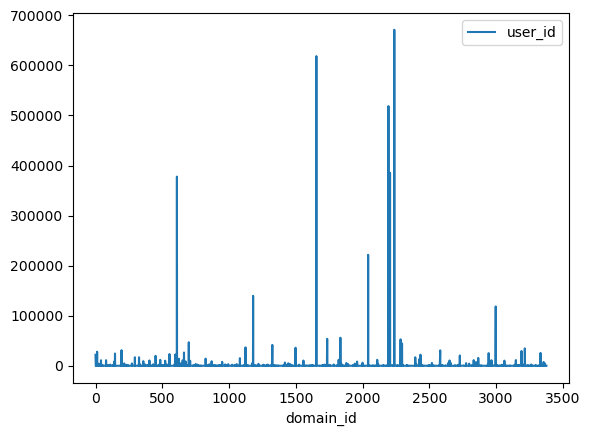

In [14]:

req1.groupby('domain_id').agg({ 'user_id' : len }).plot()

In [15]:
#user_reqs = req.groupby('user_id')['domain_id'].apply(list)
user_reqs = req1.groupby('user_id').agg(
    domain_id=('domain_id', list),
    timestamp=('timestamp', list),
    gender=('gender', list),
    age=('age', list),
    geo_id=('geo_id', list)
)
type(user_reqs), user_reqs[:10]

(pandas.core.frame.DataFrame,
                         domain_id  \
 user_id                             
 2                          [1654]   
 3                      [2867, 78]   
 6                          [3194]   
 20                          [449]   
 23                         [2729]   
 25                     [145, 145]   
 31                   [2206, 2206]   
 32                           [-1]   
 43                   [1654, 1654]   
 46       [3168, 2206, 2285, 2042]   
 
                                                 timestamp        gender  \
 user_id                                                                   
 2                                            [1712017297]           [1]   
 3                                [1712158201, 1712082733]        [1, 1]   
 6                                            [1711966047]           [0]   
 20                                           [1711961988]           [0]   
 23                                           [171205095

In [32]:
import numpy as np

train_set = []
#for index, rows in user_reqs.iterrows(): 
for (index, rows), _ in zip(user_reqs.iterrows(), range(100)): 
    #print(rows)
    temp = []
    for domain_id, timestamp, geo_id in zip(rows['domain_id'], rows['timestamp'], rows['geo_id']):
        temp.append([domain_id, timestamp, geo_id])
    inp = np.array(sorted(temp, key=lambda x: x[1])) # сортируем по timestamp
    pred = np.array([rows['gender'][0], rows['age'][0]])
    train_set.append((inp, pred))
#user_reqs
train_set[:10]

[(array([[      1654, 1712017297,        708]]), array([ 1, 61])),
 (array([[        78, 1712082733,        150],
         [      2867, 1712158201,        150]]),
  array([ 1, 55])),
 (array([[      3194, 1711966047,       3173]]), array([ 0, 46])),
 (array([[       449, 1711961988,       5368]]), array([ 0, 15])),
 (array([[      2729, 1712050954,       3833]]), array([ 1, 48])),
 (array([[       145, 1711982201,       4602],
         [       145, 1712078825,       4602]]),
  array([ 0, 59])),
 (array([[      2206, 1711971099,       3173],
         [      2206, 1711984084,       3173]]),
  array([ 1, 50])),
 (array([[        -1, 1712044334,       3948]]), array([ 1, 61])),
 (array([[      1654, 1711973633,       3833],
         [      1654, 1712057005,       3833]]),
  array([ 0, 62])),
 (array([[      3168, 1711956914,       3948],
         [      2285, 1711993097,       3948],
         [      2206, 1711998504,       3948],
         [      2042, 1712157873,       3948]]),
  array([ 1

## Объединяем паркеты

In [55]:
import numpy as np
from tqdm import tqdm

def user_list(parkets, max_users=100000000):
    train_set = {}
    for filename in tqdm(parkets):
        #print(f'Reading {prefix+filename}...')
        req = pd.read_parquet(prefix+filename)
        if low_memory:
            req.drop(columns='user_agent', axis=1, inplace=True)
        req['domain_id'] = req['referer'].apply(extract_domain_id)
        if low_memory:
            req.drop(columns='referer', axis=1, inplace=True)
        req = pd.merge(req, users, on='user_id', how='inner')
        user_reqs = req.groupby('user_id').agg(
            domain_id=('domain_id', list),
            timestamp=('timestamp', list),
            gender=('gender', list),
            age=('age', list),
            geo_id=('geo_id', list)
        )
        if low_memory:
            req = [] # освобождаем память 
        for (index, rows), _ in zip(user_reqs.iterrows(), range(max_users)):
            inp = []
            for domain_id, timestamp, geo_id in zip(rows['domain_id'], rows['timestamp'], rows['geo_id']):
                inp.append([domain_id, timestamp, geo_id])
            #inp = np.array(sorted(temp, key=lambda x: x[1])) # сортируем по timestamp
            inp = np.array(inp)
            pred = np.array([rows['gender'][0], rows['age'][0]])
            if index in train_set:
                target = train_set[index][1]
                if target[0] != pred[0]:
                    raise ValueError(f'gender mismatch ({target[0]} != {pred[0]})')
                if target[1] != pred[1]:
                    raise ValueError(f'age mismatch ({target[1]} != {pred[1]})')
                train_set[index] = (np.concatenate([train_set[index][0], inp]), target)
            else:
                train_set[index] = (inp, pred)
    return train_set

In [56]:
train_set = user_list([f'/requests/part_{i}.parquet' for i in range(3)], max_users=100)
train_set

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [35:30<00:00, 710.20s/it]


{2: (array([[      1654, 1712017297,        708]]), array([ 1, 61])),
 3: (array([[      2867, 1712158201,        150],
         [        78, 1712082733,        150],
         [      2899, 1711996672,        150]]),
  array([ 1, 55])),
 6: (array([[      3194, 1711966047,       3173],
         [      3194, 1712155187,       3173],
         [      1834, 1712102203,       3173],
         [      1123, 1711959971,       3173],
         [        40, 1711999681,       3173]]),
  array([ 0, 46])),
 20: (array([[       449, 1711961988,       5368],
         [       449, 1711963527,       5368]]),
  array([ 0, 15])),
 23: (array([[      2729, 1712050954,       3833],
         [      3334, 1712123572,       3833],
         [      3216, 1712024869,       3833],
         [      3216, 1712079162,       3833],
         [      2890, 1712079671,       3833],
         [      3216, 1711975330,       3833],
         [      2042, 1711961478,       3833],
         [      2238, 1712085510,       3833],
    

In [3]:
len(train_set)

4178040

In [1]:
import gzip
import pickle

In [60]:
with gzip.open("users.gz", "wb") as f:
    pickle.dump(train_set, f)

In [2]:
with gzip.open("users1.gz", "rb") as f:
    train_set = pickle.load(f)

## Обучаем МОДЕЛЬКУ ыыыыы

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
import numpy as np
domain_embedding_dim = 0
geo_embedding_dim = 0

count = 1000000000
for (id, (inp, target)), count in zip(train_set.items(), range(count)):
    #print(id, inp, target)

    domain_embedding_dim = max(np.max(inp[:, 0]), domain_embedding_dim)
    geo_embedding_dim = max(np.max(inp[:, 2]), geo_embedding_dim)
print(domain_embedding_dim, geo_embedding_dim)

3378 5533


In [21]:
train_dataset = list(train_set.items())

In [100]:
class MY_RNN(nn.Module):

    def __init__(self, domain_dim, geo_dim):
        super().__init__()
        self.domain_embed_dim = 256
        self.geo_embed_dim = 256
        self.hidden_size = 128

        self.domain_embed = nn.Embedding(domain_dim, self.domain_embed_dim)
        self.geo_embed = nn.Embedding(geo_dim, self.geo_embed_dim)
        self.gru = nn.GRU(self.domain_embed_dim+self.geo_embed_dim+1, self.hidden_size, batch_first=True)
        self.dense = nn.Linear(128, 2)

    def forward(self, domain_id, geo_id, hour):
        de = self.domain_embed(domain_id)
        ge = self.geo_embed(geo_id)
        x = torch.concatenate([de, ge, hour], axis=2)

        h = self.init_hidden()
        x, h = self.gru(x, h)
        x = self.dense(F.silu(x[:, -1]))
        return x

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)#.to(device)

In [101]:
model = MY_RNN(domain_embedding_dim+1, geo_embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [102]:
import time
import datetime

count = 100

#random.shuffle(train_dataset)
for i, (_, (inp, pred)) in zip(range(count), train_dataset):
    domain_id = torch.LongTensor(inp[:, 0]+1)
    geo_id = torch.LongTensor(inp[:, 2])
    hour = list(map(lambda x: datetime.datetime.fromtimestamp(x).hour, inp[:, 1]))
    hour = torch.Tensor(np.array(hour) / 12.0 - 1.0)
    
    output = model(domain_id[None, :], geo_id[None, :], hour[None, :, None])
    one_hot = np.eye(2)[pred[0]][None, :]
    loss = criterion(output, torch.Tensor(one_hot))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('loss=',loss.item())

loss= 0.7183732390403748
loss= 0.6324774026870728
loss= 0.6147666573524475
loss= 0.8275368213653564
loss= 0.7642803192138672
loss= 0.5409071445465088
loss= 0.7782421112060547
loss= 0.8877725601196289
loss= 0.859298825263977
loss= 0.8606799244880676
loss= 0.5285534262657166
loss= 0.5407691597938538
loss= 0.712968111038208
loss= 0.3734082281589508
loss= 1.1140857934951782
loss= 1.2339470386505127
loss= 0.47164568305015564
loss= 0.44854795932769775
loss= 1.063416600227356
loss= 0.823990523815155
loss= 1.6479551792144775
loss= 0.7693144083023071
loss= 0.4153549075126648
loss= 0.6040673851966858
loss= 0.3870266079902649
loss= 0.8159833550453186
loss= 1.0734798908233643
loss= 0.4562174081802368
loss= 0.8167943358421326
loss= 0.6145407557487488
loss= 1.0643515586853027
loss= 0.7821304798126221
loss= 0.7270584106445312
loss= 0.9581046104431152
loss= 0.7453376650810242
loss= 1.2471754550933838
loss= 0.8572444319725037
loss= 1.1111963987350464
loss= 0.696088969707489
loss= 1.1060960292816162
los